### Machine Learning Assignment 6 - Random Forest
Course code : CMPE-257 
Group name : Seekers 

Members :
           * Anuradha Rajashekar(012409956)
           * Ashwini Shankar Narayan(012506910)
           * Nidhi Jamar(010070593)
           * Sindhu Goudru Shivanandappa Patil(010823683)
           
 ## 1. Data Story
 
The data in the dataset is from a real Czech bank from 1999. The data is about clients and their accounts and has relation account, client, disposiiton,permanent order, transaction, loan, credit card and demographic data. Relations 'loans' and 'credit card' describe some services which bank offers to its clients. More credit cards can be issued to an account but atmost one loan can be granted for an account. The business objective is to analyze the transactional behavior of the customers and predict the loan approval status for the same customers.This is useful in cases where credit card companies provide pre approved loans for customers based on their payment and other factors. To acheive this, the below mentioned steps are followed:

* Data preparation and enrichment by adding account details - Sindhu Goudru Shivanandappa Patil

* Identifying the categorical value from the features in dataset and data transformation - Nidhi Jamar

* Test train split and function to visualize the random forest tree -  Anuradha Rajashekar

* Applying Random Forest Algorithm, Measuring the model accuracy and Visualization - Ashwini Shankar Narayan 

* Drawing conclusion from the Visualization - Team

## 2 . Dataset Selection
Dataset Link : https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions

## 3.  Data Preparation
In data preparation step, we read and preprocess the data to identify and remove invlaid values such as ? or NA. Here, we read and parse all the csv files in the dataset using the pandas dataframe.Pandas provide a unique advantage over other libraries in preprocessing the data by providing inbuilt APIs for all the math operations on selected row/column or full dataset. If there are any invalid values, fill it with the median value of the column.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydotplus
import collections
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Image

# Read the original CSV files using Pandas
trans_d = pd.read_csv("data/trans.csv")
loan_d = pd.read_csv("data/loan.csv")
account_d = pd.read_csv("data/account.csv")
client_d = pd.read_csv("data/client.csv")
disp_d = pd.read_csv("data/disp.csv")

/Users/ashwinivishwas/Environments/sjsuml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Collect the data from multiple dataset to merge together for an account_id

The loan dataset contains only loan details with accountid. No other information of the client is present in loan dataset. Therefore, we are adding account creation date, account login frequency, date of birth of the client and the district id - loaction of the branch to the loan dataset. The output of this section shows that there are no missing/ invalid values.

In [2]:
_column_date = []
_column_frequency = []
_column_district = []
_column_clientdob =[]

for c in loan_d["account_id"]:
    _result = account_d.loc[account_d["account_id"] == c]
    _column_date.append(_result['date'].iloc[0])
    _column_frequency.append(_result['frequency'].iloc[0])
    _column_district.append(_result['district_id'].iloc[0])
    _result = disp_d.loc[disp_d['account_id'] == c]
    _result = client_d.loc[client_d['client_id'] == _result['client_id'].iloc[0]]
    _column_clientdob.append(_result['birth_number'].iloc[0])

### Add extra information about account

In [3]:
loan_d['account_date'] = _column_date
loan_d['account_loginfrequency'] = _column_frequency
loan_d['account_district'] = _column_district
loan_d['client_birthNumber'] = _column_clientdob

### Look for missing data and printing unique value in column 'Status' and 'account_loginfrequency' 

In [4]:
missing = loan_d.isna().sum()
print(missing)

status_unique = list(loan_d['status'].unique())
print('Unique values in status: {}'.format(status_unique))

_freqUnique = list(loan_d['account_loginfrequency'].unique())
print('Unique values in account login frequency: {}'.format(_freqUnique))

loan_id                   0
account_id                0
date                      0
amount                    0
duration                  0
payments                  0
status                    0
account_date              0
account_loginfrequency    0
account_district          0
client_birthNumber        0
dtype: int64
Unique values in status: ['B', 'A', 'C', 'D']
Unique values in account login frequency: ['POPLATEK TYDNE', 'POPLATEK MESICNE', 'POPLATEK PO OBRATU']


## 4. Identifying a categorical value in the dataset

Here, the only two features with unique categorical and String values in the datasets is 'status' and 'account_loginfrequency'. Therefore, we need to convert them to integer values. 

From the output, we understand that 'status' feature has 4 unique values: 'A', 'B', 'C' and 'D'. 
 * A stands for contract finished, no problem, 
 * B stands for contract finished, loan not payed, 
 * C stands for running contract, OK so far and 
 * D stands for running contract, client in debt. 

Similarly, from the output, we understand that 'account_loginfrequency'(frequency of issuance of statements) has 3 unique values: 'POPLATEK TYDNE', 'POPLATEK MESICNE', 'POPLATEK PO OBRATU'.
 * "POPLATEK TYDNE" stands for monthly issuance,
 * "POPLATEK TYDNE" stands for weekly issuance and
 * "POPLATEK PO OBRATU" stands for issuance after transaction.
 
Here, we are using index values of these feature tuples to set an integer value. For example, in 'status' feature class B will be assigned an integer value 0.

### Convert String to numerical values

Replace each of the values in status and account_loginfrequency with their corresponding index. Example: Status B will be placed by 0, Status A replaced by 1 and etc.,

In [5]:
_temp = []
for c in loan_d["status"]:
    _temp.append(status_unique.index(c))
loan_d["status"] = _temp

_temp1 = []
for c in loan_d["account_loginfrequency"]:
    _temp1.append(_freqUnique.index(c))
loan_d["account_loginfrequency"] = _temp1

### Transform the data in status column to binary

The model is not able to differentiate between clients who have finished the contract and who have not finished contract clearly beacuse there is no column in loan dataset which says whether the contract is finished or not. Therefore, We are reducing the number of classes to binary i.e two classes. This is done by classifying as clients who are paying loan regularly and who are not paying regularly. In other words, transform the data in the status column to binary, by replacing 0 and 3 as 0, 1 and 2 as 1

In [6]:
# Transform the data in status column to binary, by replacing 0 and 3 as 0, 1 and 2 as 1
_temp = []
for d in loan_d['status']:
    if(d==0 or d==3):
        _temp.append(0)
    else:
        _temp.append(1)
loan_d['binary_status']  = _temp        

## 5. Split the data to 70% training data and 30% test data to train model 

In [9]:
from sklearn.model_selection import train_test_split
cols = list(loan_d.columns)
cols.remove('loan_id')
cols.remove('account_id')
cols.remove('status')
cols.remove('binary_status')
X = loan_d[cols].iloc[ :, 0:].values
Y = loan_d['status'].values
Y_bin = loan_d['binary_status']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, Y_bin, test_size=0.3, random_state=0)

## 6. Function definition to visualize the decision tree

In [10]:
def gettreeImg(clf,columns):
    dot_data = tree.export_graphviz(clf,
                                    feature_names=columns,
                                    out_file=None,
                                    filled=True,
                                    rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    colors = ('turquoise', 'orange')
    edges = collections.defaultdict(list)

    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))

    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]
            dest.set_fillcolor(colors[i])
    return graph

## 7. RANDOM FOREST on 'status' feature 

Apply Random Forest on "status" feature. Train the data for multiclass classification. Calculate accuracy of the predicted data(y_test, y_pred)

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred)*100)

86.34146341463415


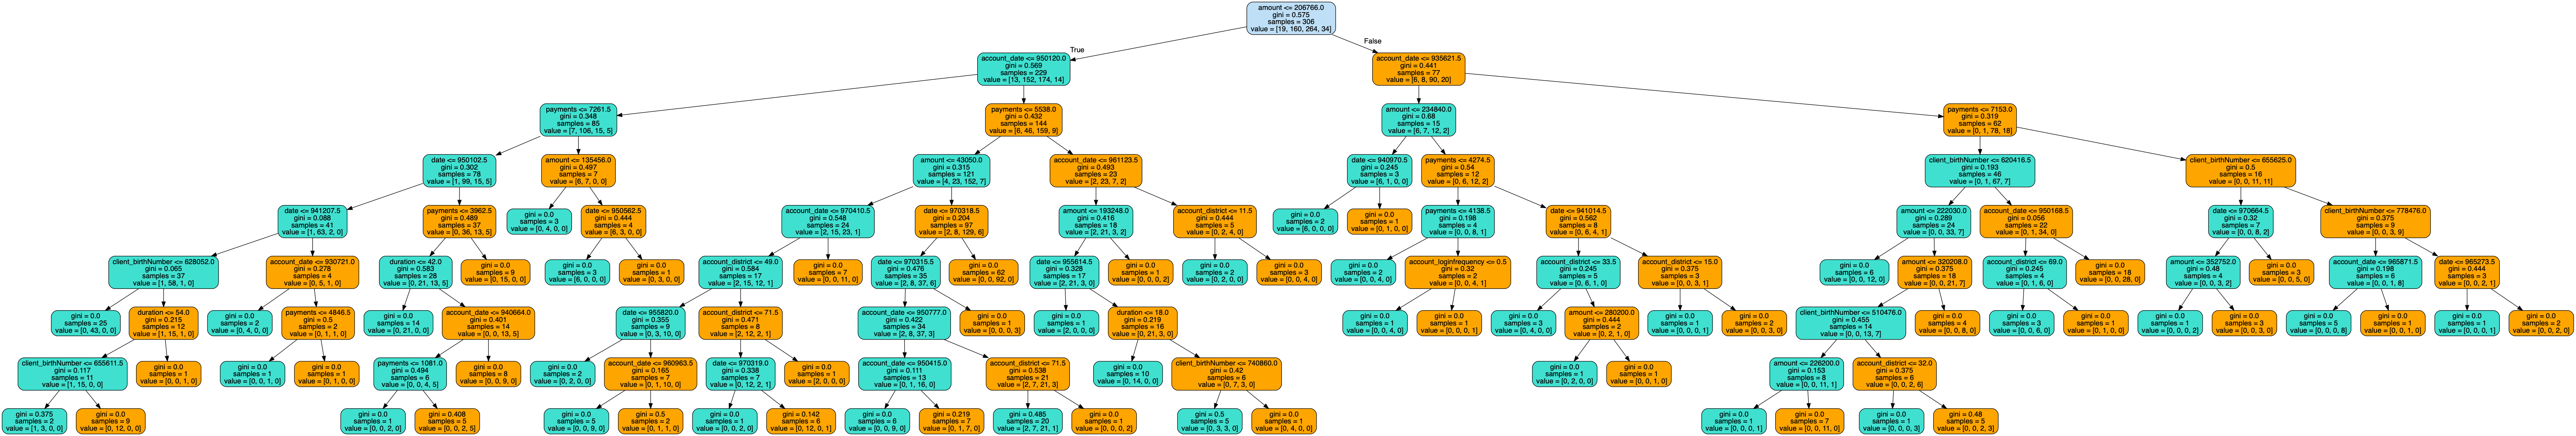

In [19]:
from IPython.display import Image
Image(gettreeImg(clf.estimators_[5],cols).create_png())

## Conclusion

The accuracy of predicting the status incase of Decision tree for multiclass classifier was 84.3%. Now, on using Random forest for predicting the same status feature for multiclass classifier the accuracy is increased to 86.34%. It is evident that the random forest has performed better since multiple decision trees are used and then the results are computed based on voting system.